## install pyspark

In [ ]:
!pip install pyspark
!pip install findspark

## Import Library

In [ ]:
# to make pyspark importable as a regular library


import pyspark

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Data Frame spark profiling
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

##Load Data

In [ ]:

#Initializing File Type
file_type = 'text'
path=r'/content/drive/MyDrive/data abd/weather_data.csv'
delimeter=','

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path)
    else:
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [ ]:
df = load_data(file_type)

## Cek data

In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col
# Menambahkan kolom ID
df= df.withColumn("Id", monotonically_increasing_id()+ 1)
df = df.withColumn("Id", col("Id").cast("integer"))
#show 5 observation in DataFrame
df.show(5)

+------------+-------------------+------------------+------------------+-----------------+------------------+---+
|    Location|          Date_Time|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh| Id|
+------------+-------------------+------------------+------------------+-----------------+------------------+---+
|   San Diego|2024-01-14 21:12:46|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|  1|
|   San Diego|2024-05-17 15:22:10| 8.734139782353598| 58.31910739552024|9.111623448229377| 27.71516125689249|  2|
|   San Diego|2024-05-11 09:30:59|11.632436312930885| 38.82017526915946|4.607511377146035|28.732951288236187|  3|
|Philadelphia|2024-02-26 17:32:39| -8.62897589569391| 54.07447397596174|3.183719747807655|26.367302672536635|  4|
| San Antonio|2024-04-29 13:23:51|39.808212974631594| 72.89990795294305|9.598282136749663|29.898621669296094|  5|
+------------+-------------------+------------------+------------------+----------------

Data ini memuat informasi meteorologi seperti suhu, kelembapan, curah hujan, dan kecepatan angin di berbagai lokasi. Nilai-nilai yang dicantumkan menunjukkan adanya variasi cuaca antar lokasi, yang dapat dimanfaatkan untuk analisis tren cuaca atau perbandingan antar wilayah.








In [ ]:

#Print Schema
df.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Temperature_C: double (nullable = true)
 |-- Humidity_pct: double (nullable = true)
 |-- Precipitation_mm: double (nullable = true)
 |-- Wind_Speed_kmh: double (nullable = true)
 |-- Id: integer (nullable = false)



In [ ]:
len(df.columns), df.columns

(7,
 ['Location',
  'Date_Time',
  'Temperature_C',
  'Humidity_pct',
  'Precipitation_mm',
  'Wind_Speed_kmh',
  'Id'])

In [ ]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] #just will select string data type
print("cat_cols:", cat_cols)
num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')] #just will select integer or double data type
print("num_cols:", num_cols)

cat_cols: ['Location']
num_cols: ['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh', 'Id']


In [ ]:
#Select column 'Id' from num_cols
num_id=num_cols.pop(-1)
print("num_id:", num_id)

#save column 'Id' in num_id variable
num_id=[num_id]

#print num_id
print(num_id)

#print num_cols
print(num_cols)

num_id: Id
['Id']
['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']


In [ ]:
# Periksa statistik ringkasan dari kolom numerik
df.select(num_cols).describe().show()


+-------+-------------------+------------------+--------------------+--------------------+
|summary|      Temperature_C|      Humidity_pct|    Precipitation_mm|      Wind_Speed_kmh|
+-------+-------------------+------------------+--------------------+--------------------+
|  count|            1000000|           1000000|             1000000|             1000000|
|   mean| 14.779704927041564| 60.02182955554031|   5.109639125976373|  14.997598129281517|
| stddev| 14.482558096887281|17.324022036939454|  2.9479970526543022|    8.66355601658893|
|    min|-19.969311093584516|30.000008666508258|8.904156590938683E-6|5.064808367705176E-5|
|    max|  39.99980055990208| 89.99997706846489|  14.971582777942082|  29.999972925526304|
+-------+-------------------+------------------+--------------------+--------------------+



 **Statistik Ringkasan untuk Kolom Numerik**:
   - Dataset memiliki 1.000.000 observasi.
   - Statistik deskriptif:
     - **Temperature_C**: Suhu rata-rata 14,78°C, berkisar dari -19,97°C hingga 39,99°C.
     - **Humidity_pct**: Kelembapan rata-rata 60,02%, berkisar dari 30,00% hingga 90,00%.
     - **Precipitation_mm**: Curah hujan rata-rata 5,11 mm, dengan nilai minimum hampir nol.
     - **Wind_Speed_kmh**: Kecepatan angin rata-rata 15,00 km/h, dengan nilai maksimum hampir 30 km/h.


In [ ]:
# Hitung jumlah pengamatan
df.count()


1000000

## cleaning data

In [ ]:
# Periksa Nilai Hilang dalam DataFrame Pyspark
def count_nulls(df_final):
    """Masukkan dataframe pyspark dan kembalikan daftar kolom dengan nilai hilang beserta total nilainya"""
    null_counts = []          # buat daftar kosong untuk menyimpan hasil
    for col in df.dtypes:     # iterasi melalui tipe data kolom, misalnya ('C0', 'bigint')
        cname = col[0]        # memisahkan nama kolom, misalnya 'C0'
        ctype = col[1]        # memisahkan tipe kolom, misalnya 'bigint'
        nulls = df.where( df[cname].isNull() ).count() # hitung jumlah nilai hilang dalam nama kolom
        result = tuple([cname, nulls])  # buat tuple baru, (nama kolom, jumlah nilai hilang)
        null_counts.append(result)      # tambahkan tuple baru ke dalam daftar hasil
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  # tampilkan hanya kolom dengan nilai hilang
    return null_counts


In [ ]:
null_counts = count_nulls(df)
null_counts

[]

In [ ]:
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

[]

## EDA

In [ ]:
# konversi dataframe spark ke pandas untuk visualisasi
df_pd2 = df.toPandas()


<ipython-input-91-5e9c6a5e94c4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


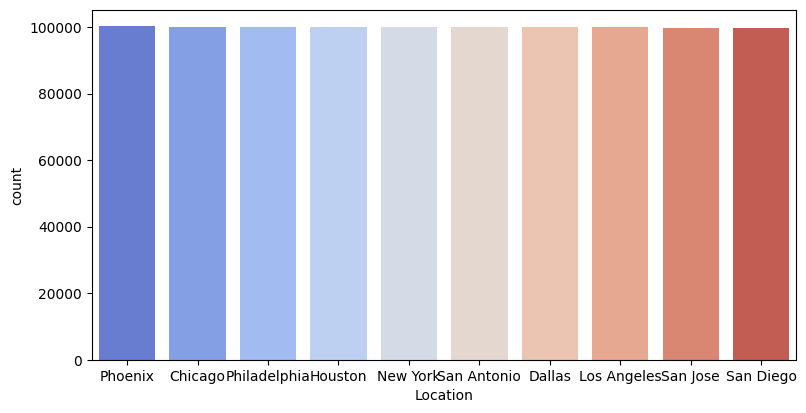

In [ ]:
# Diagram batang untuk variabel kategorikal dengan warna khusus
plt.figure(figsize=(20, 10))
plt.subplot(221)
sns.countplot(
    x='Location',
    data=df_pd2,
    order=df_pd2['Location'].value_counts().index,
    palette='coolwarm'
)
plt.show()


**Analisis Grafik**

Grafik batang menunjukkan distribusi jumlah observasi untuk variabel **Location**.

1. **Jumlah Observasi Sama**:
   - Semua lokasi, seperti Phoenix, Chicago, Philadelphia, Houston, dan lainnya, memiliki jumlah pengamatan yang hampir sama (sekitar 100.000 per lokasi).
   - Ini menunjukkan data telah diambil secara merata untuk setiap lokasi, sehingga tidak ada bias terhadap lokasi tertentu dalam dataset.


<ipython-input-68-45040dbead12>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pd2['Temperature_C'])


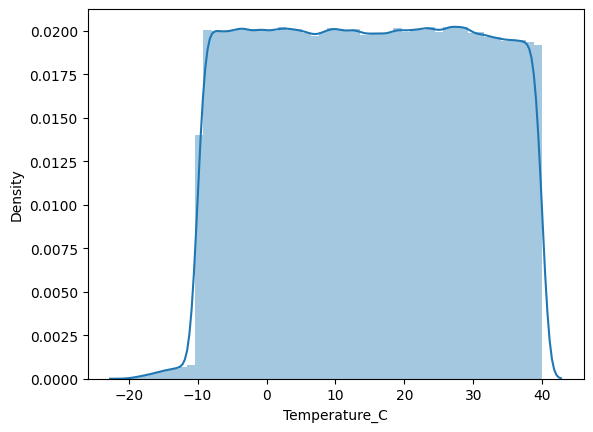

In [ ]:
# Plot kepadatan Temperature_C
# plt.figure(figsize=(24,5))
sns.distplot(df_pd2['Temperature_C'])
plt.show()


**Analisis Density Plot**

Plot kepadatan menunjukkan distribusi suhu (dalam derajat Celsius) di dataset. :

1. **Bentuk Distribusi**:
   - Distribusi suhu hampir seragam antara -10°C hingga 40°C. Ini menunjukkan bahwa suhu tersebar secara merata dalam rentang ini.

2. **Nilai Ekstrim**:
   - Terdapat nilai di bawah -10°C dan di atas 40°C, tetapi frekuensinya sangat rendah. Ini mungkin menunjukkan nilai ekstrem atau data outlier.

3. **Rentang Suhu**:
   - Rentang utama distribusi adalah dari -10°C hingga sekitar 40°C, yang merupakan rentang yang cukup luas untuk analisis data cuaca.

4. **Kepadatan Maksimum**:
   - Kepadatan tertinggi tampak berada di sekitar rentang suhu 10°C hingga 30°C. Artinya, sebagian besar data suhu berada dalam rentang ini.

Distribusi suhu yang merata ini cocok untuk analisis lebih lanjut, seperti melihat hubungan suhu dengan kelembapan atau parameter cuaca lainnya. Jika diperlukan analisis tambahan seperti identifikasi outlier atau segmentasi berdasarkan rentang suhu tertentu, beri tahu!

<ipython-input-69-51b6572e84cf>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pd2['Humidity_pct'])


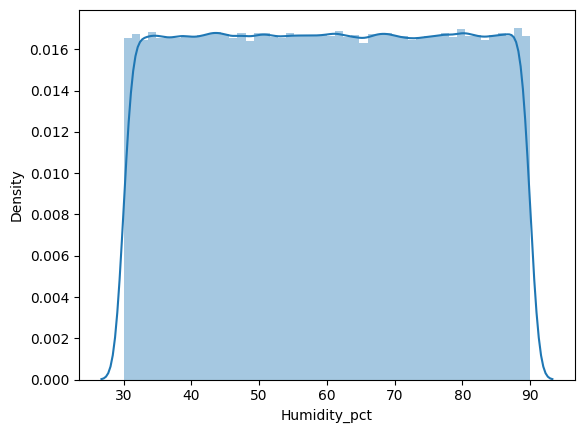

In [ ]:
#density plot Humidity_pct
sns.distplot(df_pd2['Humidity_pct'])
plt.show()

**Analisis Density Plot**

Plot kepadatan menunjukkan distribusi kelembapan udara dalam persentase (%). Berikut analisisnya:

1. **Bentuk Distribusi**:
   - Distribusi kelembapan relatif seragam antara 30% hingga 90%. Ini menunjukkan bahwa dataset memiliki cakupan kelembapan yang luas tanpa bias pada nilai tertentu.

2. **Nilai Ekstrim**:
   - Hampir tidak ada data di luar rentang 30% hingga 90%. Ini menunjukkan bahwa nilai kelembapan yang direkam berada dalam kisaran yang wajar untuk analisis meteorologi.

3. **Rentang Utama**:
   - Kelembapan tertinggi berkisar di sekitar 30% hingga 90%, dengan distribusi yang hampir seragam di seluruh rentang.

4. **Kepadatan Maksimum**:
   - Kepadatan tetap konsisten di seluruh rentang kelembapan. Ini menandakan bahwa kelembapan hampir sama terdistribusi di seluruh dataset.


Distribusi kelembapan yang seragam ini dapat membantu analisis lebih lanjut, seperti mengkaji hubungan kelembapan dengan curah hujan atau suhu.

<ipython-input-70-e054334463f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pd2['Precipitation_mm'])


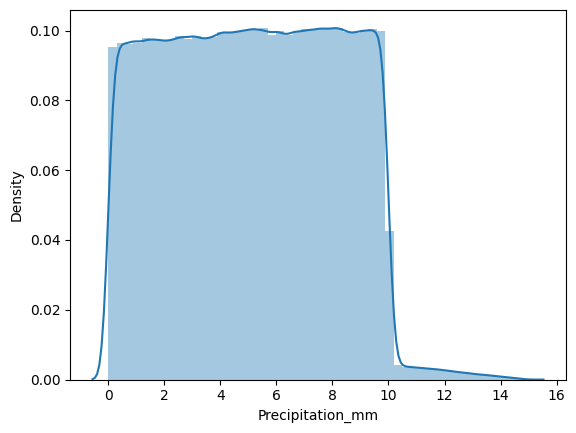

In [ ]:
#density plot Precipitation_mm
sns.distplot(df_pd2['Precipitation_mm'])
plt.show()


**Analisis Density Plot**

Plot kepadatan ini menggambarkan distribusi curah hujan dalam milimeter (mm):

1. **Bentuk Distribusi**:
   - Distribusi curah hujan hampir seragam antara 0 hingga sekitar 10 mm. Ini menunjukkan bahwa sebagian besar data curah hujan berada dalam rentang ini.

2. **Nilai Ekstrim**:
   - Terdapat nilai curah hujan yang mendekati 15 mm, tetapi frekuensinya sangat rendah. Ini kemungkinan adalah kejadian curah hujan yang sangat tinggi (outlier).

3. **Rentang Utama**:
   - Sebagian besar data curah hujan berada dalam rentang 0 hingga 10 mm, dengan distribusi yang relatif seragam.

4. **Kepadatan Maksimum**:
   - Kepadatan curah hujan tetap konstan di seluruh rentang utama, menunjukkan bahwa kejadian curah hujan dengan intensitas tertentu tersebar merata.

Distribusi curah hujan yang merata ini berguna untuk analisis hubungan curah hujan dengan parameter lain, seperti kelembapan atau suhu. Outlier di rentang atas (di atas 10 mm) mungkin memerlukan analisis lebih lanjut untuk mengidentifikasi pola ekstrem.

<ipython-input-71-d25c96dc88e2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pd2['Wind_Speed_kmh'])


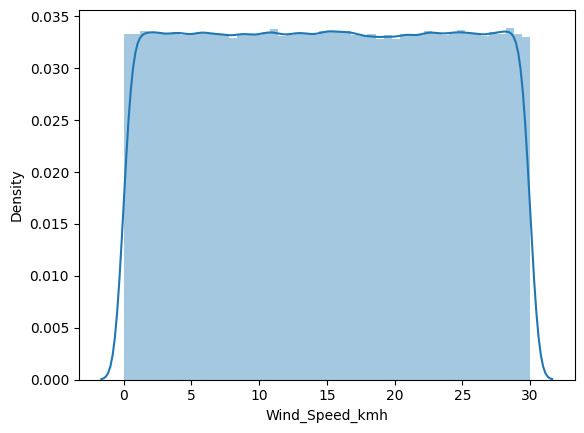

In [ ]:
#density plot Wind_Speed_kmh
sns.distplot(df_pd2['Wind_Speed_kmh'])
plt.show()


**Analisis Density Plot**

Plot kepadatan ini menggambarkan distribusi kecepatan angin dalam kilometer per jam (km/h):

1. **Bentuk Distribusi**:
   - Distribusi kecepatan angin hampir seragam antara 5 km/h hingga 30 km/h. Hal ini menunjukkan bahwa kecepatan angin dalam dataset tersebar merata di rentang ini.

2. **Nilai Ekstrim**:
   - Tidak ada nilai kecepatan angin yang ekstrem di bawah 5 km/h atau di atas 30 km/h. Ini menandakan bahwa data kecepatan angin berada dalam rentang yang masuk akal untuk analisis meteorologi.

3. **Rentang Utama**:
   - Sebagian besar kecepatan angin berada dalam rentang 5 km/h hingga 30 km/h, dengan distribusi yang cukup seragam.

4. **Kepadatan Maksimum**:
   - Kepadatan tertinggi terlihat konsisten di seluruh rentang utama, menandakan bahwa dataset mencakup berbagai kondisi angin dengan frekuensi yang merata.

**Kesimpulan**:
Distribusi kecepatan angin ini menunjukkan tidak adanya pola yang mencolok atau konsentrasi di rentang tertentu, sehingga data ini cocok untuk digunakan dalam analisis atau model prediktif terkait angin.

### cek outlier

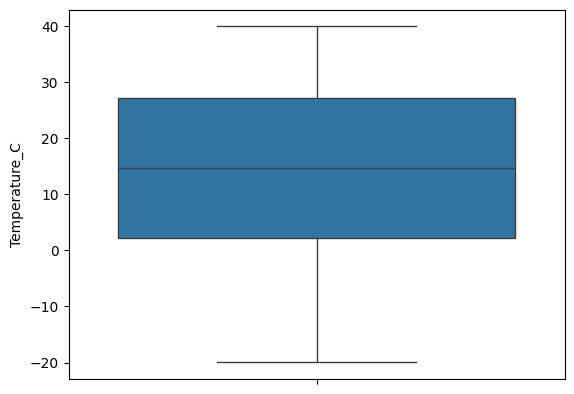

In [ ]:
#Check outlier in numerical variable: 'Temperature_C'
sns.boxplot(y="Temperature_C",data=df_pd2)
plt.show()

**Analisis Boxplot**

Boxplot ini menggambarkan distribusi suhu (Temperature_C) dalam dataset:

1. **Median**:
   - Garis di dalam kotak menunjukkan nilai median suhu. Berdasarkan boxplot, nilai median berada sekitar 15°C.

2. **Kuartil**:
   - **Kotak** merepresentasikan interquartile range (IQR), yaitu rentang antara kuartil pertama (Q1) dan kuartil ketiga (Q3).
   - Q1 berada di sekitar 5°C, sedangkan Q3 berada di sekitar 25°C. Artinya, sebagian besar data suhu (50%) berada dalam rentang ini.

3. **Rentang Data**:
   - **Garis horizontal (whiskers)** menunjukkan rentang data tanpa outlier, yaitu dari sekitar -20°C hingga 40°C.

4. **Outlier**:
   - Tidak ada tanda-tanda outlier (titik di luar whiskers) dalam boxplot ini, yang menunjukkan bahwa suhu dalam dataset tidak memiliki nilai ekstrem yang signifikan.

- Data suhu terdistribusi secara cukup merata dengan rentang utama antara -20°C hingga 40°C.
- Rentang tengah (IQR) menunjukkan bahwa sebagian besar suhu berkisar antara 5°C hingga 25°C, yang cukup representatif untuk analisis kondisi cuaca. Jika diperlukan analisis lebih lanjut (misalnya, segmentasi berdasarkan lokasi), beri tahu!

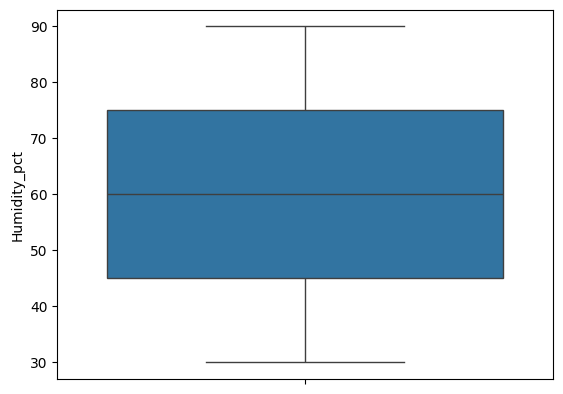

In [ ]:
#Check outlier in numerical variable: 'Humidity_pct'
sns.boxplot(y="Humidity_pct",data=df_pd2)
plt.show()

**Analisis Boxplot**

Boxplot ini menggambarkan distribusi kelembapan udara (Humidity_pct) dalam dataset:

1. **Median**:
   - Garis di dalam kotak menunjukkan nilai median kelembapan. Median berada di sekitar 60%, menunjukkan bahwa setengah dari data memiliki kelembapan di atas atau di bawah nilai ini.

2. **Kuartil**:
   - **Kotak** mewakili interquartile range (IQR), yaitu rentang antara kuartil pertama (Q1) dan kuartil ketiga (Q3).
   - Q1 berada di sekitar 50%, sedangkan Q3 berada di sekitar 70%. Ini berarti 50% data kelembapan berada dalam rentang tersebut.

3. **Rentang Data**:
   - **Garis horizontal (whiskers)** menunjukkan rentang data tanpa outlier, yaitu dari sekitar 30% hingga 90%.

4. **Outlier**:
   - Tidak ada outlier yang terdeteksi di boxplot ini, yang menunjukkan bahwa data kelembapan udara relatif seragam dan tidak memiliki nilai ekstrem.

- Kelembapan udara dalam dataset memiliki distribusi yang cukup lebar, dengan rentang utama antara 30% hingga 90%.
- Sebagian besar data kelembapan berada dalam rentang 50% hingga 70%, yang mencerminkan kondisi kelembapan udara normal di berbagai lokasi. Jika diperlukan analisis tambahan, seperti hubungan kelembapan dengan curah hujan atau suhu, beri tahu!

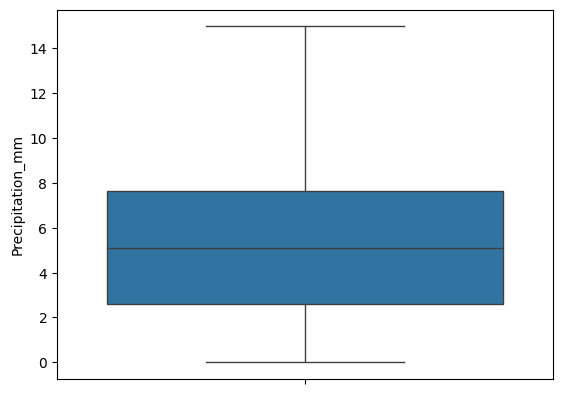

In [ ]:
#Check outlier in numerical variable: 'Humidity_pct'
sns.boxplot(y="Precipitation_mm",data=df_pd2)
plt.show()

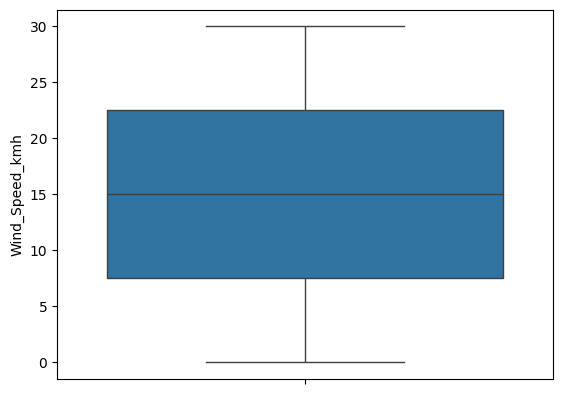

In [ ]:
#Check outlier in numerical variable: 'Humidity_pct'
sns.boxplot(y="Wind_Speed_kmh",data=df_pd2)
plt.show()

**Analisis Boxplot**

Boxplot ini menunjukkan distribusi kecepatan angin (Wind_Speed_kmh) dalam dataset:

1. **Median**:
   - Garis di dalam kotak menunjukkan nilai median kecepatan angin. Median berada di sekitar 15 km/h, yang berarti separuh data memiliki kecepatan angin di bawah atau di atas nilai ini.

2. **Kuartil**:
   - **Kotak** merepresentasikan interquartile range (IQR), yaitu rentang antara kuartil pertama (Q1) dan kuartil ketiga (Q3).
   - Q1 berada di sekitar 10 km/h, sedangkan Q3 berada di sekitar 20 km/h. Ini berarti 50% dari data kecepatan angin berada dalam rentang ini.

3. **Rentang Data**:
   - **Garis horizontal (whiskers)** menunjukkan rentang data tanpa outlier, yaitu dari sekitar 0 km/h hingga 30 km/h.

4. **Outlier**:
   - Tidak ada outlier yang terlihat dalam boxplot ini, menandakan bahwa data kecepatan angin tidak memiliki nilai ekstrem.

- Kecepatan angin dalam dataset berkisar antara 0 km/h hingga 30 km/h, dengan sebagian besar data berada di rentang 10 km/h hingga 20 km/h.
- Distribusi yang teratur ini menunjukkan bahwa dataset memiliki cakupan yang baik untuk analisis kecepatan angin. Jika diperlukan analisis tambahan, seperti hubungan kecepatan angin dengan parameter cuaca lainnya, beri tahu!

## Feature Engineering

In [ ]:
df_final2=df.drop('date_time', *cat_cols)
df_final2.show(4)

+------------------+------------------+-----------------+------------------+---+
|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh| Id|
+------------------+------------------+-----------------+------------------+---+
|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|  1|
| 8.734139782353598| 58.31910739552024|9.111623448229377| 27.71516125689249|  2|
|11.632436312930885| 38.82017526915946|4.607511377146035|28.732951288236187|  3|
| -8.62897589569391| 54.07447397596174|3.183719747807655|26.367302672536635|  4|
+------------------+------------------+-----------------+------------------+---+
only showing top 4 rows



In [ ]:
#definisikan columns untuk vector assembler processing
cols_assember=num_cols

In [ ]:
#create vector assembler dari cols_assember
assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')

In [ ]:
#transform vector assembler to dataset
final_data2 = assembler.transform(df_final2)

In [ ]:
final_data2.show(4)

+------------------+------------------+-----------------+------------------+---+--------------------+
|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh| Id|            features|
+------------------+------------------+-----------------+------------------+---+--------------------+
|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|  1|[10.6830010947153...|
| 8.734139782353598| 58.31910739552024|9.111623448229377| 27.71516125689249|  2|[8.73413978235359...|
|11.632436312930885| 38.82017526915946|4.607511377146035|28.732951288236187|  3|[11.6324363129308...|
| -8.62897589569391| 54.07447397596174|3.183719747807655|26.367302672536635|  4|[-8.6289758956939...|
+------------------+------------------+-----------------+------------------+---+--------------------+
only showing top 4 rows



## Modelling

In [ ]:
# membuat model scaler untuk normalisasi
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Hitung ScalerModel dengan melakukan fitting pada StandardScaler
scalerModel = scaler.fit(final_data2)

# Normalisasi setiap fitur agar memiliki standar deviasi satuan
cluster_final_data2 = scalerModel.transform(final_data2).select('Id', 'scaledFeatures')
cluster_final_data2.show(6)


+---+--------------------+
| Id|      scaledFeatures|
+---+--------------------+
|  1|[0.73764600309191...|
|  2|[0.60307990645870...|
|  3|[0.80320315203368...|
|  4|[-0.5958184899357...|
|  5|[2.74870038209531...|
|  6|[1.88786087970193...|
+---+--------------------+
only showing top 6 rows



## Memilih k teroptimal

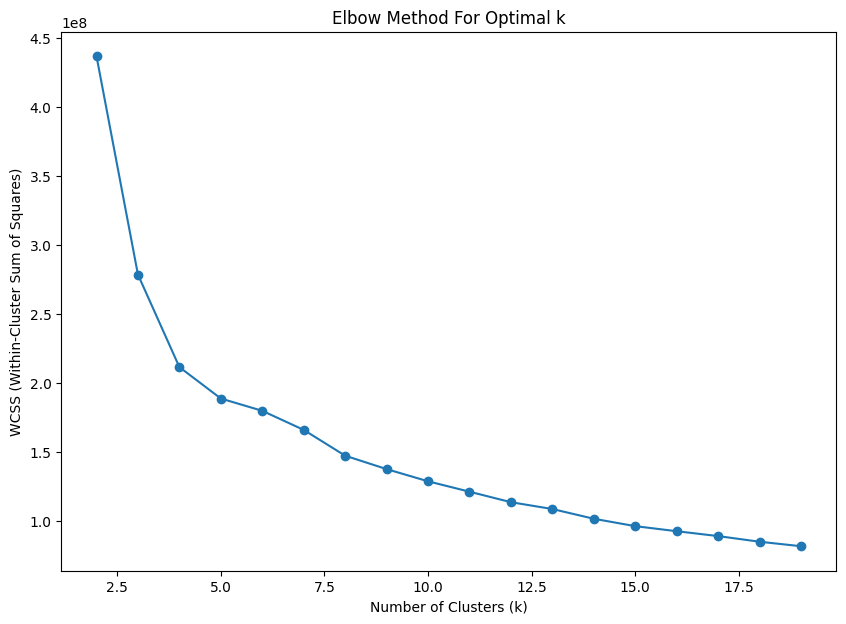

In [ ]:
# Inisialisasi array untuk menyimpan WCSS (Within-Cluster Sum of Squares)
cost2 = np.zeros(20)

# Loop untuk berbagai nilai K
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model2 = kmeans.fit(final_data2)

    # WCSS (Within-Cluster Sum of Squares)
    cost2[k] = model2.summary.trainingCost

# Plot Elbow Method
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(range(2, 20), cost2[2:20], marker='o')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('WCSS (Within-Cluster Sum of Squares)')
ax.set_title('Elbow Method For Optimal k')
plt.show()

**Analisis Elbow Plot**

Elbow plot digunakan untuk menentukan jumlah optimal klaster (k) dalam algoritma K-Means berdasarkan nilai **Within-Cluster Sum of Squares (WCSS)**. Berikut adalah analisisnya:

1. **Interpretasi Grafik**:
   - Sumbu x: Jumlah klaster (k).
   - Sumbu y: Nilai WCSS, yaitu jumlah kuadrat jarak antara titik data dan centroid klaster.

2. **Pola WCSS**:
   - Nilai WCSS menurun tajam pada awalnya ketika jumlah klaster meningkat dari 2 hingga sekitar 5.
   - Setelah titik tertentu (sekitar k=5), penurunan WCSS menjadi lebih lambat, membentuk "siku" atau "elbow".

3. **Titik Elbow**:
   - Titik elbow pada grafik terlihat sekitar **k=4**.
   - Ini menunjukkan bahwa k=5 adalah jumlah klaster yang optimal, karena penambahan klaster setelah titik ini tidak secara signifikan mengurangi nilai WCSS.

**Kesimpulan**:
- Berdasarkan Elbow Method, jumlah klaster optimal adalah **4**.
- Model K-Means dapat dilatih dengan k=4 untuk mengelompokkan data secara efektif.

## klasterisasi dengan 4 k

In [ ]:
#Create model KMeans
k = 4
kmeans2 = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_k5 = kmeans2.fit(final_data2)
centers2 = model_k5.clusterCenters()

print("Cluster Centers: ")
for center in centers2:
    print(center)

Cluster Centers: 
[ 2.24299411 75.04525829  5.12876898 14.9752179 ]
[27.34197075 44.98665473  5.09480076 14.97649082]
[27.2861881  75.00723353  5.08875407 15.00587691]
[ 2.2551979  45.05570248  5.12622552 15.03275915]


**Analisis Cluster Centers**

Berikut adalah interpretasi pusat klaster yang dihasilkan oleh algoritma K-Means:

1. **Cluster 1**:
   - **Temperature (°C)**: 2.24
   - **Humidity (%)**: 75.05
   - **Precipitation (mm)**: 5.13
   - **Wind Speed (km/h)**: 14.98
   - **Karakteristik**: Cluster ini memiliki suhu yang sangat rendah dan kelembapan tinggi, yang mungkin mewakili daerah dengan iklim dingin dan lembap.

2. **Cluster 2**:
   - **Temperature (°C)**: 27.34
   - **Humidity (%)**: 44.99
   - **Precipitation (mm)**: 5.09
   - **Wind Speed (km/h)**: 14.98
   - **Karakteristik**: Cluster ini memiliki suhu tinggi dan kelembapan rendah, kemungkinan mencerminkan wilayah dengan iklim panas dan kering.

3. **Cluster 3**:
   - **Temperature (°C)**: 27.29
   - **Humidity (%)**: 75.01
   - **Precipitation (mm)**: 5.09
   - **Wind Speed (km/h)**: 15.01
   - **Karakteristik**: Cluster ini menunjukkan suhu tinggi dengan kelembapan tinggi, mewakili wilayah beriklim tropis atau lembap.

4. **Cluster 4**:
   - **Temperature (°C)**: 2.25
   - **Humidity (%)**: 45.06
   - **Precipitation (mm)**: 5.13
   - **Wind Speed (km/h)**: 15.03
   - **Karakteristik**: Cluster ini memiliki suhu yang sangat rendah dengan kelembapan rendah, kemungkinan mewakili daerah dengan iklim dingin dan kering.

**Kesimpulan**:
- Pusat klaster menunjukkan variasi iklim yang signifikan, dengan kombinasi suhu, kelembapan, curah hujan, dan kecepatan angin yang unik.
- Analisis ini dapat membantu dalam memahami pola cuaca di berbagai wilayah atau kondisi iklim yang berbeda.

In [ ]:
# Menetapkan klaster ke setiap entri dalam data
prediction2 = model_k5.transform(final_data2).select(*num_id, *num_cols, 'prediction').collect()

# Membuat DataFrame
prediction2 = spark.createDataFrame(prediction2)

# Menampilkan DataFrame
prediction2.show(5)


+---+------------------+------------------+-----------------+------------------+----------+
| Id|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh|prediction|
+---+------------------+------------------+-----------------+------------------+----------+
|  1|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|         3|
|  2| 8.734139782353598| 58.31910739552024|9.111623448229377| 27.71516125689249|         3|
|  3|11.632436312930885| 38.82017526915946|4.607511377146035|28.732951288236187|         3|
|  4| -8.62897589569391| 54.07447397596174|3.183719747807655|26.367302672536635|         3|
|  5|39.808212974631594| 72.89990795294305|9.598282136749663|29.898621669296094|         2|
+---+------------------+------------------+-----------------+------------------+----------+
only showing top 5 rows



In [ ]:
# Mengelompokkan berdasarkan prediksi klaster
prediction2.groupBy('prediction').count().show()


+----------+------+
|prediction| count|
+----------+------+
|         0|249889|
|         1|249881|
|         3|250183|
|         2|250047|
+----------+------+



In [ ]:
#Join
prediction3=prediction2.join(df, 'Id')
prediction3.show(6)

+---+------------------+------------------+-----------------+------------------+----------+-----------+-------------------+------------------+------------------+-----------------+------------------+
| Id|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh|prediction|   Location|          Date_Time|     Temperature_C|      Humidity_pct| Precipitation_mm|    Wind_Speed_kmh|
+---+------------------+------------------+-----------------+------------------+----------+-----------+-------------------+------------------+------------------+-----------------+------------------+
|  1|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|         3|  San Diego|2024-01-14 21:12:46|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|
|  1|10.683001094715387|41.195753566944475| 4.02011871570867| 8.233540246873023|         3|   San Jose|2024-03-21 21:58:52|11.858232196263799| 76.39983719224261|3.235771225022356|11.728818193437085|
|  1|

In [ ]:
#grouping by cluster prediction and check average of age
prediction2.groupBy('prediction').agg({'Temperature_C':'mean'}).show()

+----------+------------------+
|prediction|avg(Temperature_C)|
+----------+------------------+
|         0|2.2429069312254812|
|         1|27.342023469383633|
|         3|2.2551347090587157|
|         2| 27.28598472861152|
+----------+------------------+



In [ ]:
#grouping by cluster prediction and check average of all numerical variable
prediction2.groupBy('prediction').avg().show()

+----------+------------------+------------------+------------------+---------------------+-------------------+---------------+
|prediction|           avg(Id)|avg(Temperature_C)| avg(Humidity_pct)|avg(Precipitation_mm)|avg(Wind_Speed_kmh)|avg(prediction)|
+----------+------------------+------------------+------------------+---------------------+-------------------+---------------+
|         0|250512.67684451898|2.2429069312254812| 75.04504187720988|    5.128744020794163|  14.97535636943522|            0.0|
|         1| 250164.0526930819|27.342023469383633| 44.98683499861509|    5.094800235714714| 14.976532160999952|            1.0|
|         3| 250794.8314034127|2.2551347090587157|45.055582425168915|    5.126252453873348| 15.032677071990584|            3.0|
|         2|  250152.290505385| 27.28598472861152| 75.00751055490039|    5.088752978424463| 15.005779796019082|            2.0|
+----------+------------------+------------------+------------------+---------------------+-------------

In [ ]:
#convert prediction to Pandas
pred_pd=prediction2.toPandas().set_index('Id')
#show pandas dataframe
pred_pd.head(5)

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,prediction
Id,,,,,
1,10.683001,41.195754,4.020119,8.233540,3
2,8.734140,58.319107,9.111623,27.715161,3
3,11.632436,38.820175,4.607511,28.732951,3
4,-8.628976,54.074474,3.183720,26.367303,3
5,39.808213,72.899908,9.598282,29.898622,2


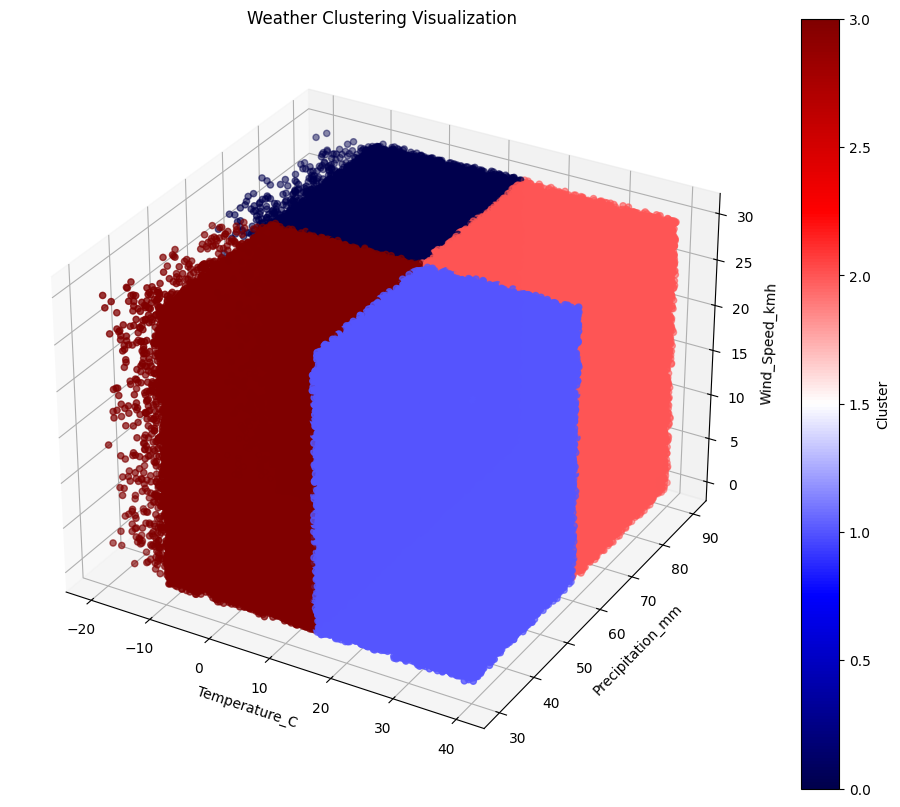

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#Create 3d visualization
# Buat visualisasi 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
sc = ax.scatter(pred_pd['Temperature_C'], pred_pd['Humidity_pct'], pred_pd['Wind_Speed_kmh'], c=pred_pd['prediction'], cmap="seismic")

# Tambahkan judul dan label sumbu
ax.set_title('Weather Clustering Visualization')
ax.set_xlabel('Temperature_C')
ax.set_ylabel('Precipitation_mm')
ax.set_zlabel('Wind_Speed_kmh')

# Tambahkan color bar
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

# Tampilkan plot
plt.show()

**Interpretasi Visualisasi Clustering**

Grafik ini menunjukkan hasil klasterisasi data cuaca berdasarkan tiga fitur utama: suhu udara (Temperature_C), kelembapan (Humidity_pct), dan curah hujan (Precipitation_mm). Setiap titik di grafik merepresentasikan data pengamatan cuaca, yang dikelompokkan ke dalam klaster dengan warna berbeda.

### **Penjelasan Tiap Klaster**
1. **Klaster 0 (Warna Biru)**:
   - **Ciri khas**: Suhu rendah hingga sedang (sekitar -20°C hingga 10°C), kelembapan tinggi (sekitar 60%-90%), dan curah hujan rendah hingga sedang.
   - **Interpretasi**: Klaster ini kemungkinan merepresentasikan kondisi cuaca di wilayah dingin dengan kelembapan tinggi dan curah hujan ringan, seperti musim dingin atau wilayah lembap dingin.

2. **Klaster 1 (Warna Merah Muda)**:
   - **Ciri khas**: Suhu tinggi (sekitar 20°C hingga 40°C), kelembapan tinggi (sekitar 60%-90%), dan curah hujan rendah hingga sedang.
   - **Interpretasi**: Klaster ini mungkin menggambarkan wilayah tropis yang lembap dan panas, dengan curah hujan sedang hingga rendah, seperti daerah tropis pada musim panas.

3. **Klaster 2 (Warna Merah Tua)**:
   - **Ciri khas**: Suhu tinggi (sekitar 20°C hingga 40°C), kelembapan rendah (sekitar 30%-50%), dan curah hujan sangat rendah.
   - **Interpretasi**: Klaster ini mewakili daerah panas dan kering, seperti gurun atau wilayah dengan iklim semi-kering.

4. **Klaster 3 (Warna Biru Tua)**:
   - **Ciri khas**: Suhu rendah hingga sedang (sekitar -20°C hingga 10°C), kelembapan rendah (sekitar 30%-50%), dan curah hujan rendah.
   - **Interpretasi**: Klaster ini mencerminkan daerah dingin dan kering, seperti wilayah musim dingin dengan sedikit curah hujan.

### **Hubungan Antar Variabel**
- **Suhu dan Kelembapan**:
  - Kelembapan cenderung lebih tinggi pada suhu rendah hingga sedang (klaster 0) dan suhu tinggi (klaster 1), tetapi lebih rendah pada suhu ekstrem tinggi (klaster 2) atau ekstrem rendah (klaster 3).
- **Curah Hujan**:
  - Curah hujan tetap rendah hingga sedang di semua klaster, tetapi distribusi kelembapan memberikan wawasan tentang perbedaan pola cuaca.

### **Aplikasi Potensial**
- **Perencanaan Cuaca**:
  - Klasifikasi ini dapat digunakan untuk memprediksi pola cuaca tertentu di wilayah yang berbeda berdasarkan kondisi iklim.
- **Mitigasi Risiko**:
  - Klaster dengan suhu ekstrem atau curah hujan rendah (klaster 2 atau 3) dapat digunakan untuk mempersiapkan mitigasi dampak perubahan iklim.
- **Pengelompokan Wilayah**:
  - Wilayah geografis dapat dikelompokkan berdasarkan klaster ini untuk analisis cuaca yang lebih sp